In [177]:
import lvm_read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
from sympy import I, Eq, Abs, N
from numpy import pi
from scipy.optimize import curve_fit


In [178]:
def read_file(filename, columns):
    file_lvm = lvm_read.read(filename, read_from_pickle=False)
    return pd.DataFrame(file_lvm[0]['data'], columns=columns)


In [179]:
noise_df = read_file('../data/Noise.lvm', ['time', 'V_S'])
frequency_noise_df = read_file('../data/frequency-noise/V_S_sweep.lvm', ['frequency', 'amplitude', 'phase'])

In [180]:
signals_df = read_file('../data/Signals.lvm', ['time', 'V_S', 'V_T', 'V_W'])

filter_500_df = read_file('../data/Filter500.lvm', ['time', 'V_S', 'V_T', 'V_W'])
filter_1905_df = read_file('../data/Filter1905.lvm', ['time', 'V_S', 'V_T', 'V_W'])
filter_8000_df = read_file('../data/Filter8000.lvm', ['time', 'V_S', 'V_T', 'V_W'])


In [181]:
V_S_sweep_df = read_file('../data/sweeps/V_S_sweep.lvm', ['frequency', 'amplitude', 'phase'])
V_T_sweep_df = read_file('../data/sweeps/V_T_sweep.lvm', ['frequency', 'amplitude', 'phase'])
V_W_sweep_df = read_file('../data/sweeps/V_W_sweep.lvm', ['frequency', 'amplitude', 'phase'])

In [182]:
# TODO: Delete badly triggered signals from frequency noise data (?)
# Trigger takes as the first point the first of the two points that caused the trigger to activate: so they are all below zero
# frequency_noise_df = frequency_noise_df[frequency_noise_df['phase'] < 0]

In [183]:
voltage_offset = noise_df['V_S'].mean() - 0.5    # TODO: rileggere il rumore a 0 volt, oppure chiedere se va bene sottrarre 5
voltage_error = noise_df['V_S'].std()

frequency_offset = frequency_noise_df['frequency'].mean() - 6000
frequency_error = frequency_noise_df['frequency'].std()

amplitude_offset = frequency_noise_df['amplitude'].mean() - 5
amplitude_error = frequency_noise_df['amplitude'].std()

phase_offset = frequency_noise_df['phase'].mean()
phase_error = frequency_noise_df['phase'].std()


signals_df[['V_S', 'V_T', 'V_W']] = signals_df[['V_S', 'V_T', 'V_W']]

filter_500_df[['V_S', 'V_T', 'V_W']] = filter_500_df[['V_S', 'V_T', 'V_W']]
filter_1905_df[['V_S', 'V_T', 'V_W']] = filter_1905_df[['V_S', 'V_T', 'V_W']]
filter_8000_df[['V_S', 'V_T', 'V_W']] = filter_8000_df[['V_S', 'V_T', 'V_W']]

V_S_sweep_df['frequency'] -= frequency_offset
V_T_sweep_df['frequency'] -= frequency_offset
V_W_sweep_df['frequency'] -= frequency_offset

V_S_sweep_df['amplitude'] -= amplitude_offset
V_T_sweep_df['amplitude'] -= amplitude_offset
V_W_sweep_df['amplitude'] -= amplitude_offset

V_S_sweep_df['phase'] -= phase_offset
V_T_sweep_df['phase'] -= phase_offset
V_W_sweep_df['phase'] -= phase_offset

In [184]:
def plot_signals(df, title):
    fig = plt.figure(figsize=(8,6))

    axes = fig.add_axes([0,0,1,1])

    axes.plot(df['time'], df['V_S'], label='Segnale', lw=0.8)
    axes.plot(df['time'], df['V_T'], label='Tweeter', lw=0.8)
    axes.plot(df['time'], df['V_W'], label='Woofer', lw=0.8)
    axes.margins(x=0)
    axes.set_xlabel('Tempo (s)')
    axes.set_ylabel('Tensione (V)')
    axes.set_title(title)

    axes.legend()
    axes.grid()


plot_signals(signals_df, 'Segnale composto (500 Hz e 8 kHz)')

plot_signals(filter_500_df, 'Bassa frequenza (500 Hz)')

plot_signals(filter_1905_df, 'Match delle ampiezze (circa 1905 Hz)')

plot_signals(filter_8000_df, 'Alta frequenza (8 kHz)')

In [185]:
R_int, R_L, R_W, R_C, R_T = sp.symbols('R_{int} R_L R_W R_C R_T', real=True, positive=True)
L, C, w, V_0, t = sp.symbols('L C \omega V_0 t', real=True, positive=True)
V = V_0*sp.exp(I*w*t)

In [186]:
Z_T = R_C + R_T + 1/(C*w*I)
Z_W = R_L + R_W + L*w*I
Z_eq = 1/(1/Z_T+1/Z_W)
Z_tot = Z_eq + R_int
i = V / Z_tot
V_eq = i * Z_eq
i_T = V_eq / Z_T
i_W = V_eq / Z_W

V_T = sp.simplify(i_T * R_T)
V_W = sp.simplify(i_W * R_W)

A_T = Abs(V_T.subs({t: 0}))
A_W = Abs(V_W.subs({t: 0}))

phi_T = sp.arg(V_T.subs({t: 0}))
phi_W = sp.arg(V_W.subs({t: 0}))


In [187]:
numerical_values = {
    R_int: 50, R_L: 203, R_W: 269.27, R_C: 0, R_T: 471.72,
    L: 46.79 * 10**-3, C: 70 * 10**-9, V_0: 5
}
uncertainties = {
    R_L: 0.19135, R_W: 0.22117, R_T: 0.312274, L: 0.4679 * 10**-3, C: 0.7 * 10**-9
}

In [188]:
def calculate_uncertainty(Y, f = w/(2*sp.pi)):
    sum = 0
    for x in uncertainties.keys():
        fixed_values = numerical_values.copy()
        x_value = fixed_values.pop(x)
        sum += ((N(Y.subs(fixed_values).diff(x).subs({x: x_value, w: 2*sp.pi*f}))) * uncertainties[x]) ** 2
    return sp.sqrt(sum)

crossover_w = (sp.solve(Eq(Abs(Z_T), Abs(Z_W)), w))[1] # 2 solutions: the last is positive
crossover_freq = crossover_w / (2*sp.pi)
crossover_freq_val = N(crossover_freq.subs(numerical_values))
crossover_freq_err_val = calculate_uncertainty(crossover_freq, crossover_freq_val)
print('crossover_frequency (Hz) = ')
print(crossover_freq_val, ' +/- ', crossover_freq_err_val)


crossover_amplitude = Abs(A_T).subs({w: crossover_w})
crossover_amplitude_val = N(crossover_amplitude.subs(numerical_values))
crossover_amplitude_err_val = calculate_uncertainty(crossover_amplitude, crossover_amplitude_val)
print('crossover amplitude (V) = ')
print(crossover_amplitude_val, ' +/- ', crossover_amplitude_err_val)

amplitude_match_w = (sp.solve(Eq(A_T, A_W), w))[1]
amplitude_match_freq = amplitude_match_w / (2 * sp.pi)
amplitude_match_freq_val = N(amplitude_match_freq.subs(numerical_values))
amplitude_match_freq_err_val = calculate_uncertainty(amplitude_match_freq, amplitude_match_freq_val)
print('amplitude match frequency (Hz) = ')
print(amplitude_match_freq_val, ' +/- ', amplitude_match_freq_err_val)


match_amplitude = Abs(A_T).subs({w: amplitude_match_w})
match_amplitude_val = N(match_amplitude.subs(numerical_values))
match_amplitude_err_val = calculate_uncertainty(match_amplitude, match_amplitude_val)
print('match amplitude (V) = ')
print(match_amplitude_val, ' +/- ', match_amplitude_err_val)

# from ideal circuit
phi_match_w_theory = sp.sqrt((R_L+R_W) / (C*L * (R_C+R_T)))
phi_match_freq_theory = phi_match_w_theory / (2*pi)
phi_match_freq_theory_val = N(phi_match_freq_theory.subs(numerical_values))
phi_match_freq_theory_err_val = calculate_uncertainty(phi_match_freq_theory, phi_match_freq_theory_val)
print('phase match frequency (Hz) = ')
print(phi_match_freq_theory_val, ' +/- ', phi_match_freq_theory_err_val)

In [189]:
# Remove bad points in frequency analysis
"""
to_drop = []
for i in range(1, V_S_sweep_df.shape[0] - 1):
    if (abs(V_S_sweep_df.loc[i, 'amplitude'] - (V_S_sweep_df.loc[i-1, 'amplitude'] + V_S_sweep_df.loc[i+1, 'amplitude']) / 2) > 0.05):
        to_drop.append(i)
for i in to_drop:
    V_S_sweep_df.drop(i, inplace=True)
    V_T_sweep_df.drop(i, inplace=True)
    V_W_sweep_df.drop(i, inplace=True)
"""

"\nto_drop = []\nfor i in range(1, V_S_sweep_df.shape[0] - 1):\n    if (abs(V_S_sweep_df.loc[i, 'amplitude'] - (V_S_sweep_df.loc[i-1, 'amplitude'] + V_S_sweep_df.loc[i+1, 'amplitude']) / 2) > 0.05):\n        to_drop.append(i)\nfor i in to_drop:\n    V_S_sweep_df.drop(i, inplace=True)\n    V_T_sweep_df.drop(i, inplace=True)\n    V_W_sweep_df.drop(i, inplace=True)\n"

fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Ampiezza in funzione della frequenza')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['amplitude'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['amplitude'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['amplitude'], label='Woofer rilevato')


A_Ts = np.array([N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()])
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = np.array([N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency'], V_0: V_S_sweep_df.loc[i,'amplitude']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()])
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')

"""
A_Ts = np.array([N(A_T.subs({w: 2*pi*V_T_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_T_sweep_df.index.tolist()])
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Previsione tweeter')

A_Ws = np.array([N(A_W.subs({w: 2*pi*V_W_sweep_df.loc[i,'frequency']}).subs(numerical_values)) for i in V_W_sweep_df.index.tolist()])
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Previsione woofer')
"""

"""
boosted_woofer = A_Ws / numerical_values[R_W] * (numerical_values[R_W] + numerical_values[R_L])
axes.plot(V_W_sweep_df['frequency'], boosted_woofer, label='Woofer ideale')
"""

axes.legend()
axes.grid()


In [190]:
def substitute_except(expr, syms):
    new_num_values = { key: numerical_values[key] for key in numerical_values if key not in syms }
    new_expr = expr.subs(new_num_values)
    return new_expr

    
def compute_chi_square(xdata, ydata, yerr, fit_func):
    if yerr == 0: return np.Infinity
    s = 0
    for i in range(xdata.count()):
        x = xdata[i]
        y = ydata[i]
        y_fit = fit_func(x)
        s += (y - y_fit)**2 / yerr**2
    return s


def fit(expr, ind_var, params, x, y, yerr=0):
    func_parameters = [ind_var] + params
    initial_values = []
    for param in params:
        initial_values.append(numerical_values[param])
    new_func = substitute_except(expr, func_parameters)
    to_fit = sp.lambdify(func_parameters, new_func)
    parameters, covariance = curve_fit(to_fit, x, y, p0=initial_values)
    new_values = {}
    for i in range(len(params)):
        new_values[params[i]] = parameters[i]
    fit_func = sp.lambdify(ind_var, new_func.subs(new_values))
    chi_square = compute_chi_square(x, y, yerr, fit_func)
    dof = x.count() - len(params)
    print('parameters = ', parameters)
    print('chi square / dof = ', chi_square, ' / ', dof)
    return fit_func



In [206]:
A_T_fit = fit(A_T, w, [C, L, R_L, R_int, R_T], V_T_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_T_sweep_df['amplitude'], yerr=amplitude_error)

parameters =  [7.34984746e-08 3.81625798e-01 2.22506568e+03 1.33860645e+02
 4.60429966e+02]
chi square / dof =  1926.7151795809377  /  44


In [205]:
A_W_fit = fit(A_W, w, [C, L, R_L, R_int], V_W_sweep_df['frequency'].apply(lambda f: 2*pi*f), V_W_sweep_df['amplitude'], yerr=amplitude_error)

parameters =  [6.86788330e-08 4.98219319e-02 1.65427384e+02 9.28976790e+01]
chi square / dof =  63.78885553990095  /  45


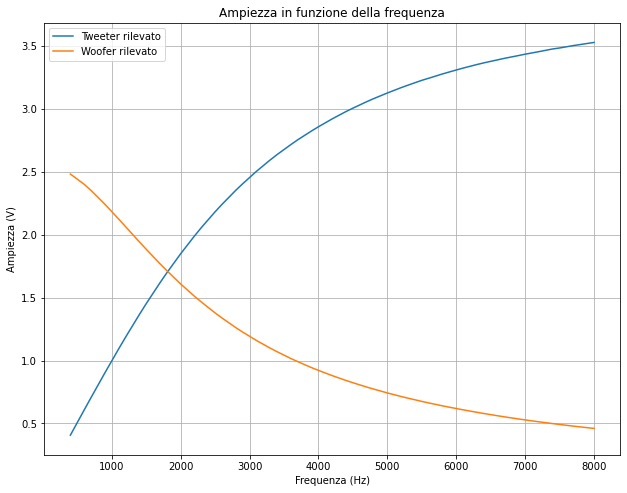

In [171]:
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Ampiezza in funzione della frequenza')

axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['amplitude'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['amplitude'], label='Woofer rilevato')
"""
A_Ts = V_T_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(A_T_fit)
axes.plot(V_T_sweep_df['frequency'], A_Ts, label='Fit tweeter')

A_Ws = V_W_sweep_df['frequency'].apply(lambda f: 2*np.pi*f).apply(A_W_fit)
axes.plot(V_W_sweep_df['frequency'], A_Ws, label='Fit woofer')
"""
axes.legend()
axes.grid()


# Zoom sulla frequenza di match delle ampiezze
fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Ampiezza (V)')
axes.set_title('Match delle ampiezze')

a = 1500
b = 2200
df_T = V_T_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]
df_W = V_W_sweep_df[(a < V_T_sweep_df['frequency']) & (V_T_sweep_df['frequency'] < b)]

axes.plot(df_T['frequency'], df_T['amplitude'], label='Tweeter rilevato', color='orange')
axes.plot(df_W['frequency'], df_W['amplitude'], label='Woofer rilevato', color='green')
axes.errorbar(float(amplitude_match_freq_val), float(match_amplitude_val), xerr=3*float(amplitude_match_freq_err_val), yerr=3*float(match_amplitude_err_val), fmt='.k', lw=0.8, label='Match delle ampiezze previsto')

axes.legend()
axes.grid()


fig = plt.figure(figsize=(8, 6))

axes = fig.add_axes([0,0,1,1])

axes.set_xlabel('Frequenza (Hz)')
axes.set_ylabel('Fase (°)')
axes.set_title('Fase in funzione della frequenza')

axes.plot(V_S_sweep_df['frequency'], V_S_sweep_df['phase'], label='Segnale rilevato')
axes.plot(V_T_sweep_df['frequency'], V_T_sweep_df['phase'], label='Tweeter rilevato')
axes.plot(V_W_sweep_df['frequency'], V_W_sweep_df['phase'], label='Woofer rilevato')
axes.plot(V_W_sweep_df['frequency'], V_T_sweep_df['phase'] + V_W_sweep_df['phase'], label='Somma delle fasi')

fs = np.linspace(200, 8500, 200)

phi_Ts = np.array([N(phi_T.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ts, label='Previsione tweeter')

phi_Ws = np.array([N(phi_W.subs(numerical_values).subs({w: 2*pi*x})) * 180 / pi for x in fs])
axes.plot(fs, phi_Ws, label='Previsione woofer')

axes.plot(fs, phi_Ts + phi_Ws, label='Somma previsioni')

axes.legend()
axes.grid()